<a href="https://colab.research.google.com/github/glazar01/lyric-pulse-sentiment-analysis/blob/main/final_analysis_model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 26 18:28:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 342.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 295.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 327.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 340.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 326.2 MB/s eta 0:00:00


In [ ]:
!pip3 install torch

In [ ]:
# import libraries
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import torch

# Our Data

In [ ]:
url = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/SingleLabel.csv"
s_data = pd.read_csv(url)

In [ ]:
s_data

,artist,genre,title,album,year,lyrics,label
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness
...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness


In [ ]:
s_data['label'].unique()

array(['Sadness', 'Tension', 'Tenderness'], dtype=object)

# Model4: distilbert-base-uncased-emotion

## link
 https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion?text=I+like+you.+I+love+you

## description:
smaller and faster model compared to other bert

## emotion categories
love, joy, surprise, sadness, anger, fear

## interesting thought
no neutral emotions

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


small example how the pipeline works

In [ ]:
prediction_0 = classifier(s_data['lyrics'][0],)

In [ ]:
prediction_0

[[{'label': 'sadness', 'score': 0.2264464944601059},
  {'label': 'joy', 'score': 0.15882547199726105},
  {'label': 'love', 'score': 0.0046456437557935715},
  {'label': 'anger', 'score': 0.436862975358963},
  {'label': 'fear', 'score': 0.17143386602401733},
  {'label': 'surprise', 'score': 0.001785537227988243}]]

Model 4 with token512 split

In [ ]:
from nltk.tokenize import sent_tokenize
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [ ]:
# Initialize the DistilBERT tokenizer
model = DistilBertForSequenceClassification.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')
tokenizer = DistilBertTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

In [ ]:
def determine_optimal_token_size(tokenizer, model, sample_text):
    input_ids = tokenizer.encode(sample_text, add_special_tokens=False)

    max_length = 512  # Maximum sequence length for BERT-based models

    while max_length > 0:
        try:
            segment_ids = tokenizer.build_inputs_with_special_tokens(input_ids[:max_length])
            model_input = torch.tensor([segment_ids]).to(model.device)
            with torch.no_grad():  # Ensure we're not computing gradients
                model(model_input)  # Test if the model can handle the input size
            return max_length - 2  # Subtracting the space for [CLS] and [SEP]
        except RuntimeError:
            max_length -= 1

    return 0

In [ ]:
# Sample a lyric from your dataset
sample_lyric = s_data['lyrics'].iloc[999]

optimal_token_size = determine_optimal_token_size(tokenizer, model, sample_lyric)
print(f"The optimal token size (excluding special tokens) for the sample lyric is: {optimal_token_size}")

Token indices sequence length is longer than the specified maximum sequence length for this model (878 > 512). Running this sequence through the model will result in indexing errors


The optimal token size (excluding special tokens) for the sample lyric is: 508


In [ ]:
optimal = []
for i in range(len(s_data['label'])):
  sample_lyric = s_data['lyrics'].iloc[i]
  optimal.append(determine_optimal_token_size(tokenizer, model, sample_lyric))

In [ ]:
min(optimal)

508

In [ ]:
max(optimal)

510

In [ ]:
def get_scores_from_ids(input_ids):
    # Ensure input is a tensor and on the model's device
    input_tensor = torch.tensor([input_ids]).to(model.device)
    with torch.no_grad():
        outputs = model(input_tensor)
    logits = outputs[0]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    labels = model.config.id2label
    scores = {labels[i]: prob for i, prob in enumerate(probs[0].tolist())}
    return scores

In [ ]:
def process_lyric(lyric, tokenizer, model):
    input_ids = tokenizer.encode(lyric, add_special_tokens=False)
    aggregated_scores = {'sadness': 0, 'joy': 0, 'love': 0, 'anger': 0, 'fear': 0, 'surprise': 0}

    for i in range(0, len(input_ids), 508):
        segment_ids = input_ids[i:i+508]
        segment_ids_with_special_tokens = tokenizer.build_inputs_with_special_tokens(segment_ids)

        # Process even if the segment is shorter than 512
        scores = get_scores_from_ids(segment_ids_with_special_tokens)

        for label in aggregated_scores:
            aggregated_scores[label] += scores[label]

    # Average the scores
    num_segments = len(input_ids) // 508 + (1 if len(input_ids) % 508 != 0 else 0)
    for label in aggregated_scores:
        aggregated_scores[label] /= num_segments

    return aggregated_scores


In [ ]:
# Process the entire dataset
results = []
for lyric in s_data['lyrics']:
    result = process_lyric(lyric, tokenizer, model)
    results.append(result)

In [ ]:
# Add results to the DataFrame
s_data['sentiment_scores_512'] = results

In [ ]:
s_data

,artist,genre,title,album,year,lyrics,label,sentiment_scores_512
0,Nirvana,Rock,You Know You’re Right,Nirvana,2002.0,I will never bother you\nI will never promise ...,Sadness,"{'sadness': 0.2264465093612671, 'joy': 0.15882..."
1,Damian Marley,Reggae,Here We Go,Stony Hill,2017.0,Here we go\nMy big ego is gonna get me in trou...,Tension,"{'sadness': 0.006851407932117581, 'joy': 0.541..."
2,The Mission UK,Rock,Jade,Another Fall from Grace,2016.0,She came as Lolita dressed as Venus\nAnd adorn...,Tenderness,"{'sadness': 0.035244014114141464, 'joy': 0.871..."
3,UB40,Reggae,Food For Thought,Signing Off,1980.0,"Ivory Madonna, dying in the dust\nWaiting for ...",Sadness,"{'sadness': 0.8164834380149841, 'joy': 0.00783..."
4,Johnny Cash,Country,I’ve Been Everywhere,American II: Unchained,1996.0,I was totin' my pack along the dusty Winnemucc...,Sadness,"{'sadness': 0.03270221408456564, 'joy': 0.0370..."
...,...,...,...,...,...,...,...,...
1155,The Beatles,Rock,Yesterday,Help!,1965.0,Yesterday\nAll my troubles seemed so far away\...,Sadness,"{'sadness': 0.24019074440002441, 'joy': 0.0724..."
1156,The Sundays,Rock,Love,Blind,1992.0,Picture myself as a thin white child\nBack to ...,Tenderness,"{'sadness': 0.734485387802124, 'joy': 0.185853..."
1157,The Cure,Rock,Killing an Arab,Boys Don’t Cry,1978.0,Standing on the beach\nWith a gun in my hand\n...,Tension,"{'sadness': 0.1327538639307022, 'joy': 0.32100..."
1158,Garth Brooks,Country,Mom,Man Against Machine,2014.0,"A little baby told God\nHey I'm kinda scared, ...",Tenderness,"{'sadness': 0.006649191956967115, 'joy': 0.069..."


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(s_data, *['year'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(s_data, *['genre'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(s_data, *['label'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(s_data, *['year', 'count()', 'genre'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(s_data, *['year', 'count()', 'label'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(s_data, *['year'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(s_data, *['genre', 'label'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(s_data, *['year', 'genre'], **{'inner': 'box'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(s_data, *['year', 'label'], **{'inner': 'box'})
chart

split them into paragraphs to test

In [ ]:
from transformers import pipeline, AutoTokenizer
tokenizer1 = AutoTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

In [ ]:
def get_avg_emotion_for_text(text):
    # Check tokenized length
    tokenized_length = len(tokenizer1.tokenize(text))
    if tokenized_length > 508:
        # Truncate or handle the long text here. For simplicity, we'll just return an empty dictionary.
        # Alternatively, you can split the text further or truncate it.
        return {}
    scores = classifier(text)
    return {item['label']: item['score'] for item in scores[0]}

In [ ]:
def get_avg_emotion_for_song(lyrics):
    paragraphs = lyrics.split("\n\n")
    all_scores_list = []

    for p in paragraphs:
        if len(tokenizer1.tokenize(p)) > 508:  # If token count exceeds the limit
            sentences = p.split(".")
            sentence_scores = [get_avg_emotion_for_text(s) for s in sentences if s.strip() != '']

            aggregated_sentence_scores = {}
            for scores in sentence_scores:
                for label, score in scores.items():
                    if label not in aggregated_sentence_scores:
                        aggregated_sentence_scores[label] = []
                    aggregated_sentence_scores[label].append(score)

            paragraph_avg_scores = {label: sum(scores) / len(scores) for label, scores in aggregated_sentence_scores.items()}
            all_scores_list.append(paragraph_avg_scores)
        else:
            all_scores_list.append(get_avg_emotion_for_text(p))

    aggregated_scores = {}
    for scores in all_scores_list:
        for label, score in scores.items():
            if label not in aggregated_scores:
                aggregated_scores[label] = []
            aggregated_scores[label].append(score)

    avg_scores = {label: sum(scores) / len(scores) for label, scores in aggregated_scores.items()}
    return avg_scores


In [ ]:
s_data['avg_emotion'] = s_data['lyrics'].apply(get_avg_emotion_for_song)

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


# calculate the dominant emotion for 512 token size split

In [ ]:
#extract the dominant emotion from 512 token size split
dominant_emotions_512 = [max(row, key=row.get) for row in results]

In [ ]:
s_data['dominant_emotions_512'] = dominant_emotions_512

calculate the dominant emotion for paragraphs--> sentence split

In [ ]:
results1 = list(s_data['avg_emotion'])

In [ ]:
# there are some empty rows
dominant_emotions_s = [max(row, key=row.get) for row in results1 if row]

In [ ]:
# indices of empty rows
empty_rows_indices = [index for index, row in enumerate(results1) if not row]
print(empty_rows_indices)

[61, 281, 330, 379, 382, 401, 419, 431, 455, 457, 607, 634, 1011, 1019, 1039, 1111]


In [ ]:
s_data['avg_emotion'][61]

{}

In [ ]:
for index in empty_rows_indices:
    lyrics = s_data.at[index, 'lyrics']
    sentences = lyrics.split("\n")

    all_scores_list = []
    for s in sentences:
        s = s.strip()
        if s:
            score = get_avg_emotion_for_text(s)
            if score:  # Only append if the score is not empty
                all_scores_list.append(score)

    aggregated_scores = {}
    for scores in all_scores_list:
        for label, score in scores.items():
            if label not in aggregated_scores:
                aggregated_scores[label] = []
            aggregated_scores[label].append(score)

    avg_scores = {label: sum(scores) / len(scores) for label, scores in aggregated_scores.items()}
    results1[index] = avg_scores

In [ ]:
dominant_emotions_s = [max(row, key=row.get) for row in results1 ]

In [ ]:
s_data['dominant_emotions_s'] = dominant_emotions_s

# split into sentences

## Splitting Method 1: using spacy "en_core_web_sm"

In [ ]:
import pandas as pd
import spacy

# Load the English model
split_s = spacy.load("en_core_web_sm")

# Function to split lyrics into sentences
def split_lyrics(lyrics):
    doc = split_s(lyrics)
    return [sent.text for sent in doc.sents]

In [ ]:
# Apply the function to the 'lyrics' column
s_data['sentences'] = s_data['lyrics'].apply(split_lyrics)

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
from transformers import AutoTokenizer
from collections import defaultdict

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bhadresh-savani/distilbert-base-uncased-emotion')

In [ ]:
def split_into_chunks(text, max_length=508):
    """Split a text into chunks that are no longer than max_length."""
    tokens = tokenizer.tokenize(text)

    # Split tokens into chunks of max_length
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]

    # Convert token chunks back to strings
    return [tokenizer.convert_tokens_to_string(chunk) for chunk in chunks]


In [ ]:
def get_average_emotion_scores(sentences):
    aggregated_scores = defaultdict(float)

    total_chunks = 0  # Count the total chunks to correctly average later
    for sentence in sentences:
        chunks = split_into_chunks(sentence)
        total_chunks += len(chunks)
        for chunk in chunks:
            predictions = classifier(chunk)
            for item in predictions[0]:
                aggregated_scores[item['label']] += item['score']

    # Average the scores
    average_scores = {emotion: total_score / total_chunks for emotion, total_score in aggregated_scores.items()}
    return average_scores

In [ ]:
s_data['average_emotion_s'] = s_data['sentences'].apply(get_average_emotion_scores)

Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
s_data.to_csv('/content/drive/MyDrive/s_data_model4.csv')

In [ ]:
s_data['average_emotion_s'][0]

{'sadness': 0.09607010371242226,
 'joy': 0.7100575543855402,
 'love': 0.005148595074636184,
 'anger': 0.09535420110279863,
 'fear': 0.092539777090265,
 'surprise': 0.0008297922296068547}

In [ ]:
results_s = s_data['average_emotion_s']

In [ ]:
emotions_s = [max(row, key=row.get) for row in results_s]

In [ ]:
s_data['emotion_s'] = emotions_s

## Splitting Method 2: using "\ n" as a cutting point


## Mapping


---


In the original data, we have 3 lables, sadness, tension and tenderness. But in the prediction, there are 6 emotions, sadness, joy, love, anger, fear, surprise respectively. Now we need to map them together.

---
here we propose,<br>
sadness --> sadness <br>
joy --> tenderness <br>
love --> tenderness <br>
anger --> tension <br>
fear --> tension <br>
surprise --> tenderness <br>


---
note: we can also calculte different accuracies if we categorize "surprise" into different categories



In [ ]:
emotion_mapping = {
    'sadness': 'Sadness',
    'joy': 'Tenderness',
    'love': 'Tenderness',
    'anger': 'Tension',
    'fear': 'Tension',
    'surprise': 'Tension'
}

# mapping data from sentence splitting method

In [ ]:
mapped_emotion_s = [emotion_mapping[dominant] for dominant in s_data['emotion_s']]

In [ ]:
s_data['mapped_emotion_s'] = mapped_emotion_s

In [ ]:
original_emotion_s = s_data['label']
correct_predictions_s = sum(original == predicted for original, predicted in zip(original_emotion_s, mapped_emotion_s))
accuracy_s = correct_predictions_s / len(s_data)

In [ ]:
accuracy_s

0.4224137931034483

# mapping data from 512 token splitting method

In [ ]:
mapped_emotion_512 = [emotion_mapping[dominant] for dominant in s_data['dominant_emotions_512']]

In [ ]:
mapped_emotion_s = [emotion_mapping[dominant] for dominant in s_data['dominant_emotions_s']]

In [ ]:
s_data['mapped_emotion_512'] = mapped_emotion_512
s_data['mapped_emotion_s'] = mapped_emotion_s

In [ ]:
original_emotion = s_data['label']
correct_predictions_512 = sum(original == predicted for original, predicted in zip(original_emotion, mapped_emotion_512))
accuracy_512 = correct_predictions_512 / len(s_data)

In [ ]:
accuracy_512

0.425

In [ ]:
correct_predictions_s = sum(original == predicted for original, predicted in zip(original_emotion, mapped_emotion_s))
accuracy_s = correct_predictions_s / len(s_data)

In [ ]:
accuracy_s

0.43448275862068964

# multi label model with sentence split

In [ ]:
url_m = "https://raw.githubusercontent.com/glazar01/lyric-pulse-sentiment-analysis/main/data/MultiLabel.csv"
m_data = pd.read_csv(url_m)

In [ ]:
m_data['average_emotion_m'] = s_data['average_emotion_s']

In [ ]:
emotion_mapping_m = {
    'sadness': 'Sadness',
    'joy': 'Amazement',
    'love': 'Tenderness',
    'anger': 'Tension',
    'fear': 'Tension',
    'surprise': 'Joyful activation'
}

In [ ]:
# Function to map emotions
def map_emotions_m(emotion_dict):
    return {emotion_mapping_m[k]: v for k, v in emotion_dict.items()}

In [ ]:
# Apply the function to the 'average_emotion_m' column
m_data['mapped_emotions_m'] = m_data['average_emotion_m'].apply(map_emotions_m)

In [ ]:
results_m = m_data['mapped_emotions_m']
emotions_m = [max(row, key=row.get) for row in results_m]

In [ ]:
m_data['emotions_m'] = emotions_m

In [ ]:
m_data.to_csv('/content/drive/MyDrive/m_data_model4.csv')

In [ ]:
#percision
original_emotion_m = m_data['labels']
correct_predictions_m = sum(predicted in original for original, predicted in zip(original_emotion_m, emotions_m))
accuracy_m = correct_predictions_m / len(m_data)

In [ ]:
accuracy_m

0.3629310344827586

# Visualizations

In [ ]:
pip install matplotlib seaborn

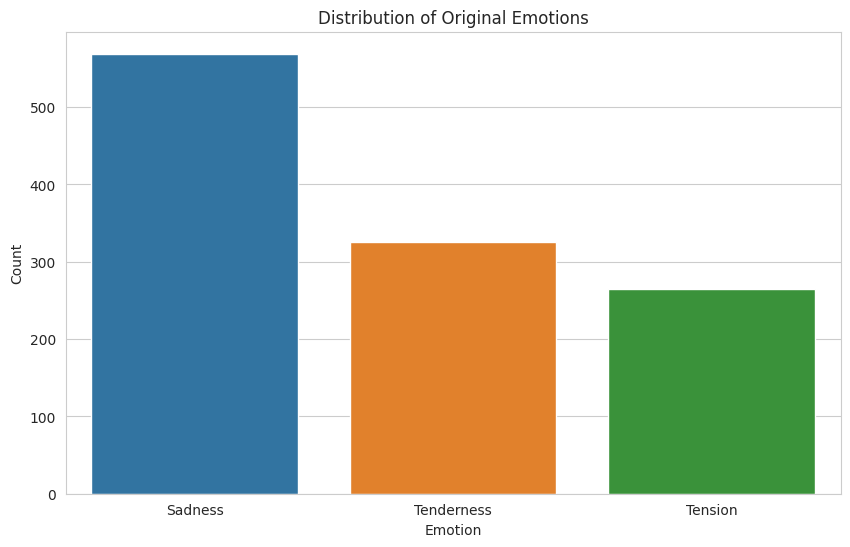

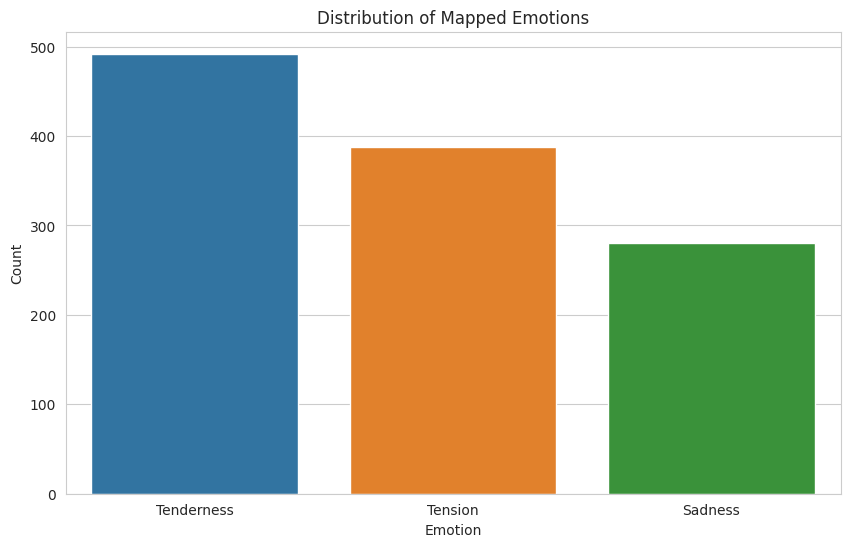

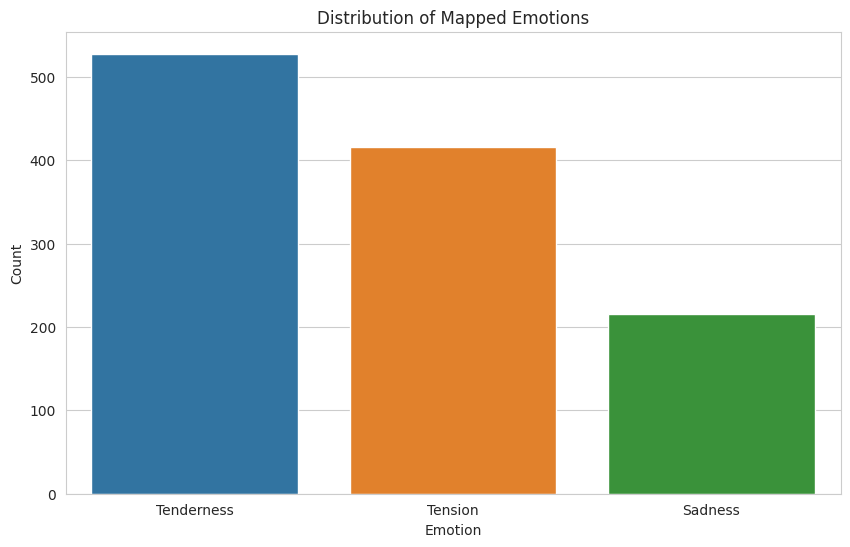

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn
sns.set_style("whitegrid")

# Plot for original_emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='label', order=s_data['label'].value_counts().index)
plt.title('Distribution of Original Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

# Plot for mapped_emotion_512 distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='mapped_emotion_512', order=s_data['mapped_emotion_512'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

# Plot for mapped_emotion_s distribution (paragraph split)
plt.figure(figsize=(10, 6))
sns.countplot(data=s_data, x='mapped_emotion_s', order=s_data['mapped_emotion_s'].value_counts().index)
plt.title('Distribution of Mapped Emotions')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.show()

single label 512 tokens split

<ipython-input-100-45e4fe547005>:10: RuntimeWarning: invalid value encountered in divide
  accuracies_512 = cm_512.diagonal() / cm_512.sum(axis=1)


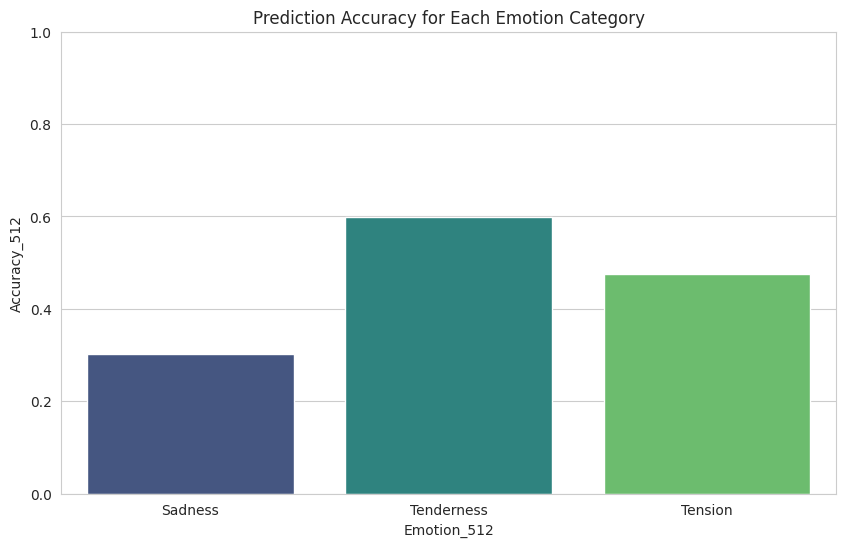

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix for 512
cm_512 = confusion_matrix(original_emotion, mapped_emotion_512, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies_512 = cm_512.diagonal() / cm_512.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy_512 = dict(zip(list(emotion_mapping.values()), accuracies_512))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy_512.keys()), y=list(emotion_accuracy_512.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy_512')
plt.xlabel('Emotion_512')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()

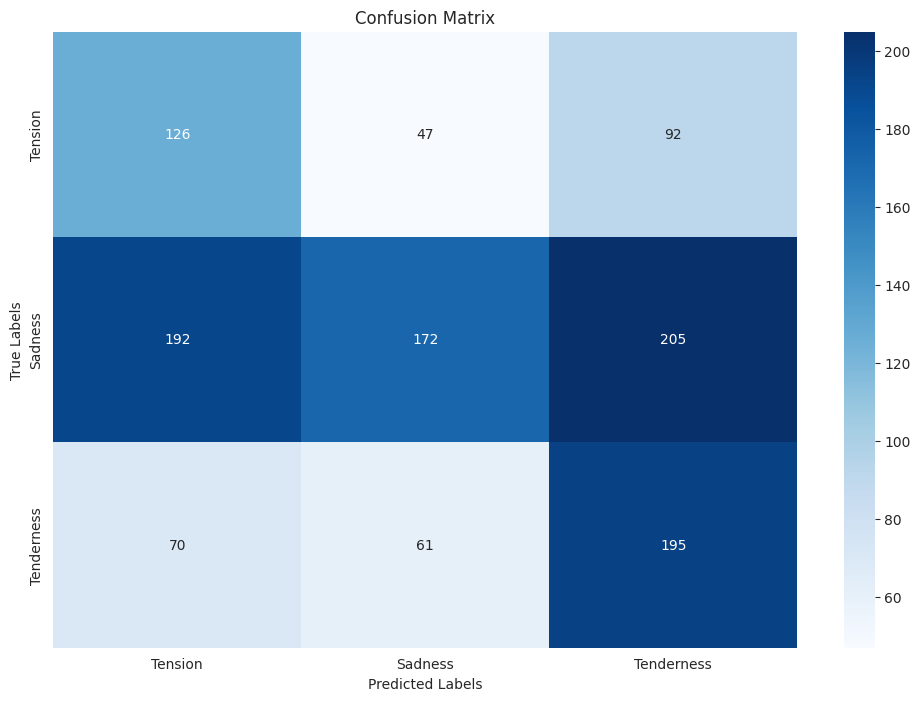

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels = list(set(original_emotion) | set(mapped_emotion_512))

# Calculate the confusion matrix
cm1 = confusion_matrix(original_emotion, mapped_emotion_512, labels=unique_labels)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm1, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


model 4 single label paragraph split visualization

<ipython-input-103-2293f1679c0c>:10: RuntimeWarning: invalid value encountered in divide
  accuracies_s = cm_s.diagonal() / cm_s.sum(axis=1)


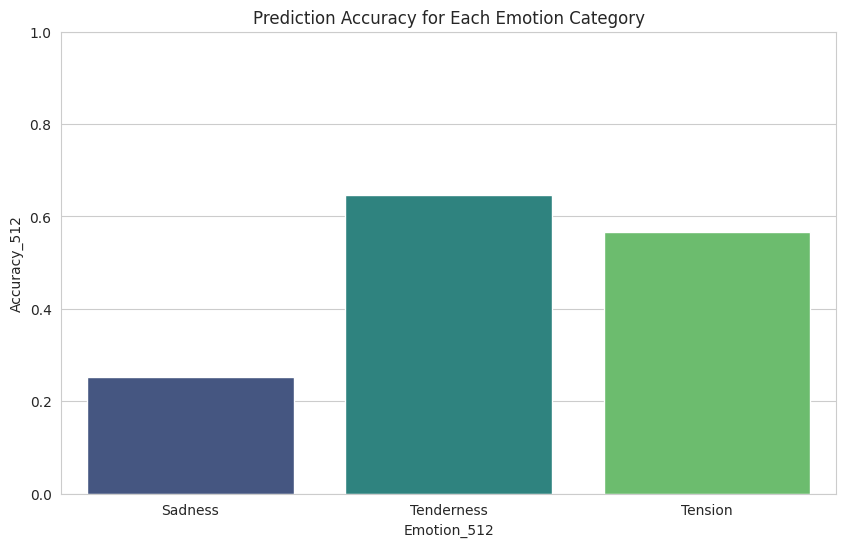

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix for 512
cm_s = confusion_matrix(original_emotion, mapped_emotion_s, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies_s = cm_s.diagonal() / cm_s.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy_s = dict(zip(list(emotion_mapping.values()), accuracies_s))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy_s.keys()), y=list(emotion_accuracy_s.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy_512')
plt.xlabel('Emotion_512')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
plt.show()

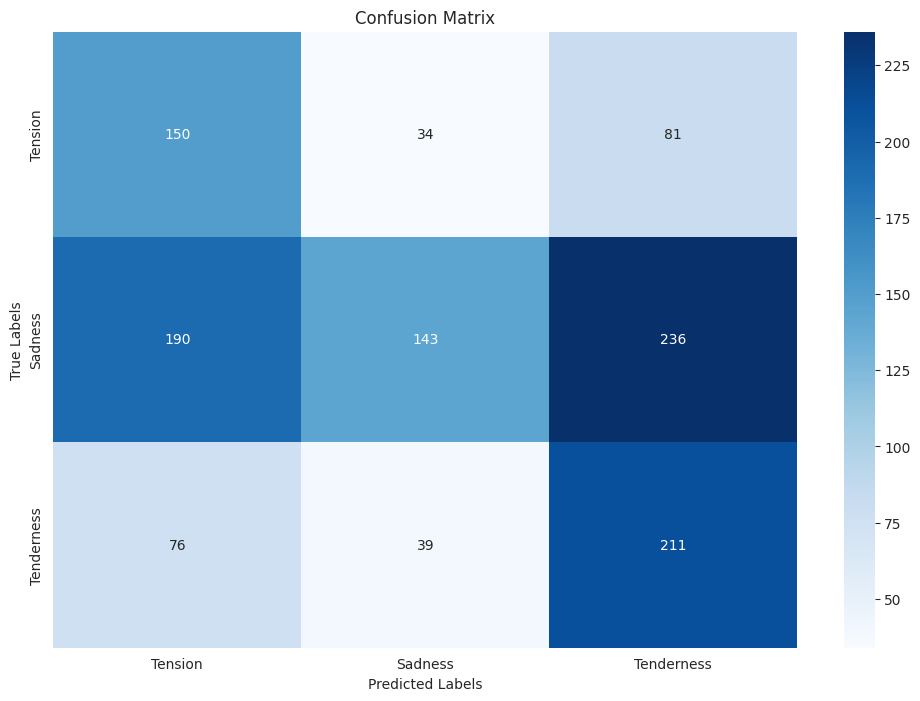

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels_1 = list(set(original_emotion) | set(mapped_emotion_s))

# Calculate the confusion matrix
cm2 = confusion_matrix(original_emotion, mapped_emotion_s, labels=unique_labels_1)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm2, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels_1, yticklabels=unique_labels_1)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### splitting the sentence result visualiztaion

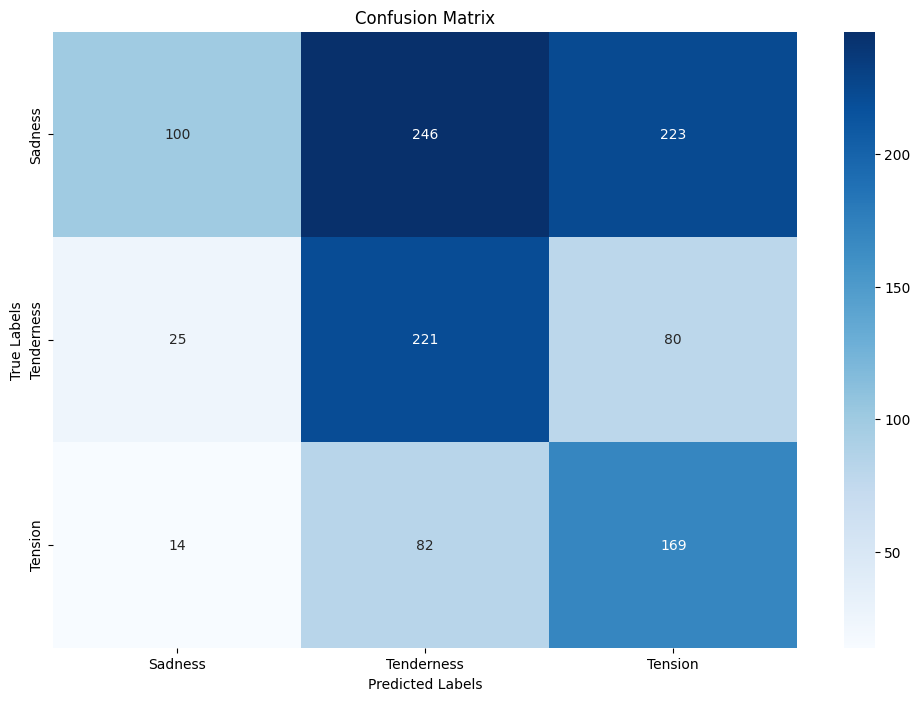

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique labels from both original and mapped emotions
unique_labels_s = list(set(original_emotion_s) | set(mapped_emotion_s))

# Calculate the confusion matrix
cm_s = confusion_matrix(original_emotion_s, mapped_emotion_s, labels=unique_labels_s)

# Visualize the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm_s, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels_s, yticklabels=unique_labels_s)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
path = "/content/drive/MyDrive/Essential/model4_single_sentence.png"
plt.savefig(path)
plt.show()

<ipython-input-56-146bfaf03475>:10: RuntimeWarning: invalid value encountered in divide
  accuracies_s = cm_s.diagonal() / cm_s.sum(axis=1)


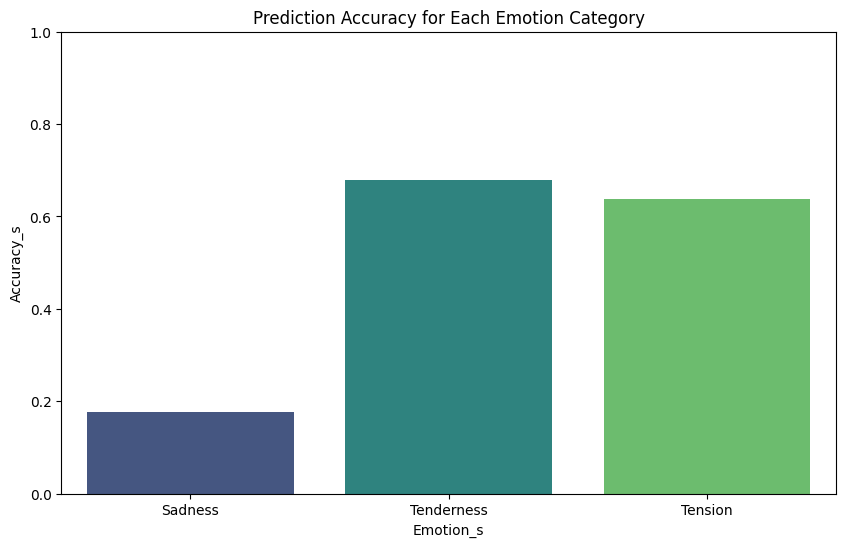

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix for 512
cm_s = confusion_matrix(original_emotion_s, mapped_emotion_s, labels=list(emotion_mapping.values()))

# Calculate per-category accuracy
accuracies_s = cm_s.diagonal() / cm_s.sum(axis=1)

# Mapping of emotions to their accuracies
emotion_accuracy_s = dict(zip(list(emotion_mapping.values()), accuracies_s))

# Visualize the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_accuracy_s.keys()), y=list(emotion_accuracy_s.values()), palette="viridis")
plt.title('Prediction Accuracy for Each Emotion Category')
plt.ylabel('Accuracy_s')
plt.xlabel('Emotion_s')
plt.ylim(0, 1)  # Setting y-axis limits to be between 0 and 1 for clarity
path = "/content/drive/MyDrive/Essential/model4_single_sentence.png"
plt.savefig(path)
plt.show()